# Forecasting
This notebook contains steps for forecasting the percentage increase in Queens.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

import pickle

from SCRIPT.eval_tools import *

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
with open('PKL/timeseries_queens_p.pkl', 'rb') as fp:
    df = pickle.load(fp)

In [3]:
df.index = pd.DatetimeIndex(df.index.values, freq='infer')

In [4]:
df.columns = df.columns.astype(str)

In [5]:
trdf = df.iloc[:int(len(df)*.8)]

In [6]:
tedf = df.iloc[int(len(df)*.8):]

For the initial univariate modeling, I will compare the top 5 zipcodes with the highest deviation from the average and one zipcode closest to the average.

In [7]:
select_zipcode = ['11101', '11693', '11692', '11694', '11103']

I'll run each model for each of the zipcodes. Then take the sum of squares across all predictions of all 5 zipcodes to compare between models.

# 1. SARIMA 
Our model has a seasonality and controllable stationarity. 

In [8]:
sel_df = trdf[select_zipcode[0]]

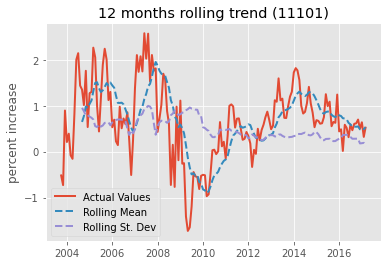

In [9]:
plot_moving_avg(sel_df, 12, select_zipcode[0])

In [10]:
run_dickyey_fuller(sel_df, select_zipcode[0])

Null Rejected (p = 0.0396). 11101 time series is stationary


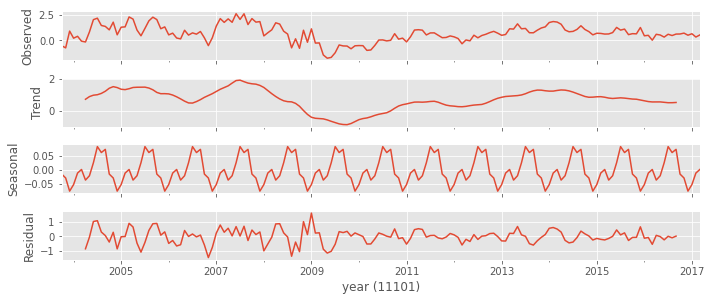

In [11]:
plot_decomposition(sel_df, select_zipcode[0])

Time series is stationary but shows seasonality.

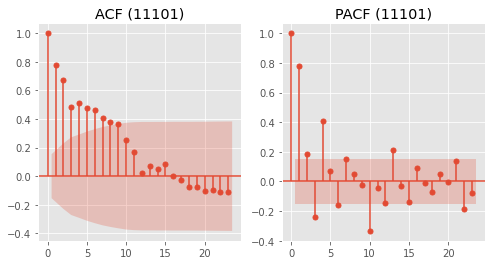

In [12]:
def_acf_pacf(sel_df, select_zipcode[0])

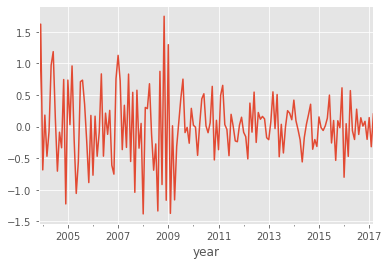

In [13]:
plot_basic(sel_df.diff(1)[1:])

In [14]:
run_dickyey_fuller(sel_df.diff(1)[1:], select_zipcode[0])

Null Rejected (p = 0.0044). 11101 time series is stationary


### SARIMA

First let's find the best parameters that yield the lowest AIC.

In [15]:
from itertools import product

In [ ]:
p = q = range(0, 4)
d = range(0, 2)
pdq = list(product(p, d, q))
spdq = [x + (12,) for x in pdq]
min_param = [None, None, 500]

for param in pdq:
    for sparam in spdq:
        try:
            mod = SARIMAX(sel_df, order=param,
                          seasonal_order=sparam,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            results = mod.fit()

            if results.aic < min_param[2]: 
                min_param[0] = param
                min_param[1] = sparam
                min_param[2] = results.aic
        except:
            continue
print(f'pdq: {min_param[0]}, PDQS: {min_param[1]} - AIC: {round(min_param[2], 2)}')


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check

In [75]:
sarima = SARIMAX(sel_df, order=(2, 1, 1), 
        seasonal_order=(0, 0, 0, 12), 
        enforce_stationarity=False, 
        enforce_invertibility=False)
model = sarima.fit()
print(model.summary())

                           Statespace Model Results                           
Dep. Variable:                  11101   No. Observations:                  162
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -108.798
Date:                Tue, 06 Oct 2020   AIC                            225.595
Time:                        09:33:14   BIC                            237.871
Sample:                    10-01-2003   HQIC                           230.580
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5528      0.160     -3.455      0.001      -0.866      -0.239
ar.L2          0.1927      0.093      2.081      0.037       0.011       0.374
ma.L1          2.3682      0.813      2.912      0.0

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


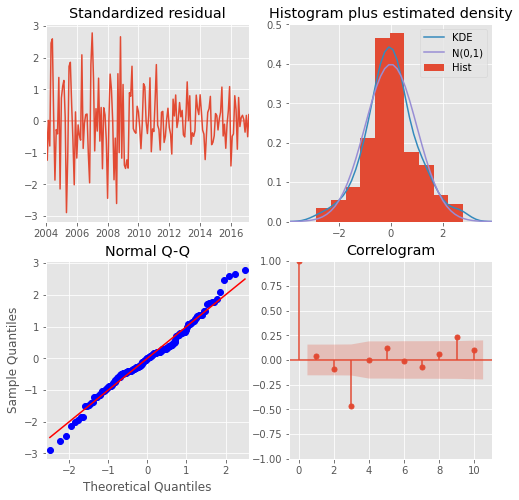

In [76]:
model.plot_diagnostics(figsize = (8, 8))
plt.show()

In [92]:
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

In [93]:
def RMSE(y_true, y_pred):
    return sqrt(MSE(y_true, y_pred))

In [105]:
def get_RMSE(data, model, term = 40, show = True):
    pred = model.predict(-term)
    sel_dat = data[-term:]
    rmse = RMSE(sel_dat, pred)
    if show:
        plt.figure(figsize=(8,6))
        data.plot(label='Actual')
        pred.plot(label='Predicted')
        plt.legend(loc='best')
        plt.show()
    return rmse

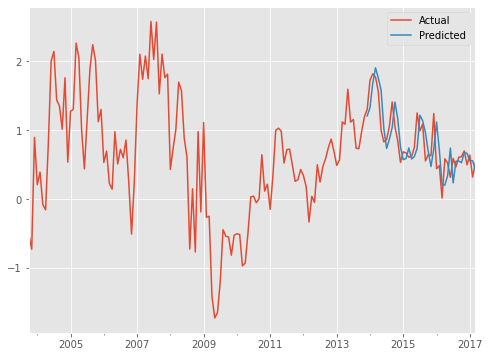

0.27798937567280424

In [106]:
get_RMSE(sel_df, model)

In [ ]:
def plot_forecast(df, forecast, steps = 40):
    forecast_ci = forecast.conf_int()
    ax = df.plot(label='observed', figsize=(8, 6))
    forecast.predicted_mean.plot(ax=ax, label='forecast')
    ax.fill_between(forecast_ci.index,
                    forecast_ci.iloc[:, 0],
                    forecast_ci.iloc[:, 1], color='k', alpha=0.1)
    ax.set_xlabel('Date')
    ax.set_ylabel('Percent Increase')

    plt.legend()
    plt.show()

In [ ]:
def test_rmse(df, model, steps = 40, show = True):
    forecast = model.get_forecast(steps = steps)
    
    if show:
        plot_forecast(df, forecast, steps = steps)
    return forecast

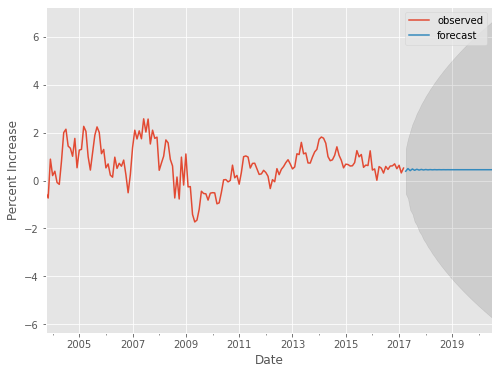

In [126]:
plot_forecast(sel_df, model)